In [9]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
  return 3*x**2 - 4*x + 5

In [3]:
f(3)

20

In [13]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):#fallback string representation
    return f"Value(data={self.data})"
  
  def __add__(self, other):#overload + operator
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other): #overload * operator
    other = other if  isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __rmul__(self, other):  #right-side multiplication
    return self * other
  
  def __pow__(self, other): #overload ** operator
    out = Value(self.data**other, (self, ), f'**{other}')
    
    def _backward():
      self.grad += other * (self.data**(other -1)) * out.grad
    out._backward = _backward
    
    return out
  def __neg__(self):  #overload unary - operator
    return self * Value(-1.0)
  
  def __sub__(self, other):   #overload - operator
    return self + (-other)
  
  def __truediv__(self, other):   #overload / operator
    return self * other**-1
  
  def exp(self):    #exponential function   
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward(): 
      self.grad += out.data * out.grad
    out._backward = _backward
    
    return out
  
  def log(self):  #natural logarithm
    x = self.data
    out = Value(math.log(x), (self, ), 'log')
    
    def _backward():
      self.grad += (1/x) * out.grad
    out._backward = _backward
    
    return out

  def tanh(self):   #hyperbolic tangent function
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def backward(self): #backpropagation
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()




$\tanh(x)=\frac{e^{2x}-1}{e^{2x}+1}$

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [21]:
x1=Value(2.0, label='x1')
x2=Value(0.0, label='x2')
w1=Value(-3.0, label='w1')
w2=Value(1.0, label='w2')
b=Value(6.8813735870195432, label='b')
x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'
y=x1w1x2w2 + b; y.label='y'
o=((2*y).exp()-1)/((2*y).exp()+1); o.label='o'

In [18]:
x1=Value(2.0, label='x1')
x2=Value(0.0, label='x2')
w1=Value(-3.0, label='w1')
w2=Value(1.0, label='w2')
b=Value(6.8813735870195432, label='b')
x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'
y=x1w1x2w2 + b; y.label='y'
oh=y.tanh(); oh.label='oh'

In [22]:
o.backward()

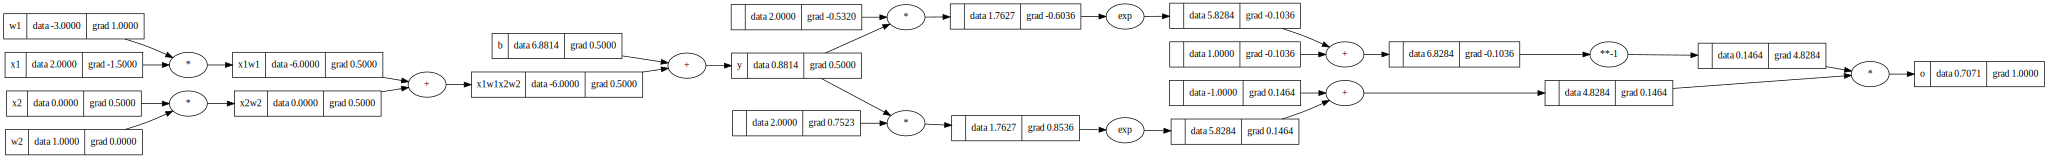

In [23]:
draw_dot(o)

In [19]:
oh.backward()

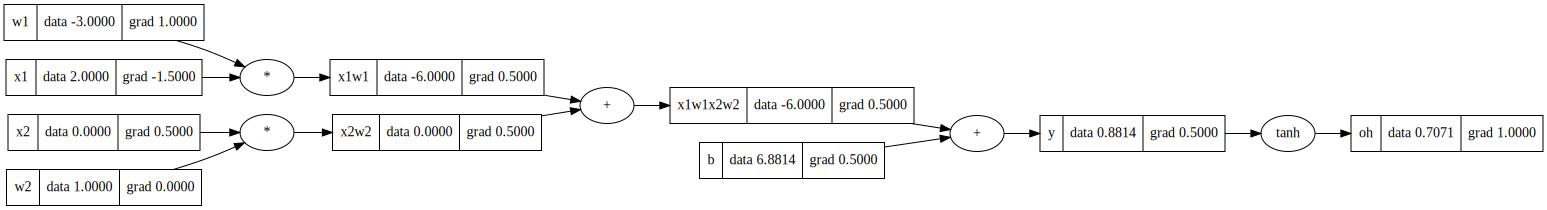

In [20]:
draw_dot(oh)

映射关系的内部延拓不影响原有梯度反向传播结果

In [ ]:
%pip install torch


   ---------------------------------------- 0.0/110.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/110.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/110.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/110.9 MB ? eta -:--:--
   -- ------------------------------------- 5.8/110.9 MB 48.3 MB/s eta 0:00:03
   -- ------------------------------------- 6.0/110.9 MB 14.7 MB/s eta 0:00:08
   -- ------------------------------------- 6.0/110.9 MB 14.7 MB/s eta 0:00:08
   ---- ----------------------------------- 11.3/110.9 MB 15.1 MB/s eta 0:00:07
   ---- ----------------------------------- 12.1/110.9 MB 11.6 MB/s eta 0:00:09
   ---- ----------------------------------- 12.3/110.9 MB 10.9 MB/s eta 0:00:10
   ----- ---------------------------------- 14.7/110.9 MB 10.0 MB/s eta 0:00:10
   ------ --------------------------------- 18.9/110.9 MB 12.4 MB/s eta 0:00:08
   -------- ------------------------------- 24.4/110.9 MB 12.9 MB/s eta 0:00:07

In [2]:
import torch

In [3]:
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad_(True)
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad_(True)
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad_(True)
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad_(True)
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad_(True)
n = w1*x1 + w2*x2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()
print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [5]:
torch.Tensor([[1,2,3],[4,5,6]])

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [6]:
torch.Tensor([[1,2,3],[4,5,6]]).shape

torch.Size([2, 3])

In [4]:
torch.Tensor([2.0]).double()

tensor([2.], dtype=torch.float64)